# ORIE 4580/5580/5581 Assignment 6

#### Students: Alex Gardocki (rag325), Anurag Yadav (ay468)

### Github link:(https://github.com/anurag3451/ORIE-5580-Homework)


### Instructions


* Due Thursday, November 20, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on Canvas. Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.



### Essential reading

The chapters on [Poisson Process](https://canvas.cornell.edu/courses/80773/modules/items/3269525), [DTMCs](https://canvas.cornell.edu/courses/80773/modules/items/3426077) and [CTMCs](https://canvas.cornell.edu/courses/80773/modules/items/3426086) from Mor Harchol-Balter, posted on Canvas

<hr><hr>

# Question 1 (The Spotify Shuffle)

**(a)** (10 pts) You have a Spotify playlist with $n$ songs playing on shuffle. Suppose Spotify truly picks a random song each time -- you want to see how many songs it takes on average to play **every song** on your playlist. Build a simulator to estimate this for a different values of $n$, and use this to try and guess the function.

*Note 1*: We saw this in class as the `coupon collector' problem -- we also saw a way to compute the exact expected time in an earlier clicker question...

*Note 2*: Try and pick a large range of $n$ to get a sense of the function, and also make sure you always show your CIs!


<hr>

## Ans.

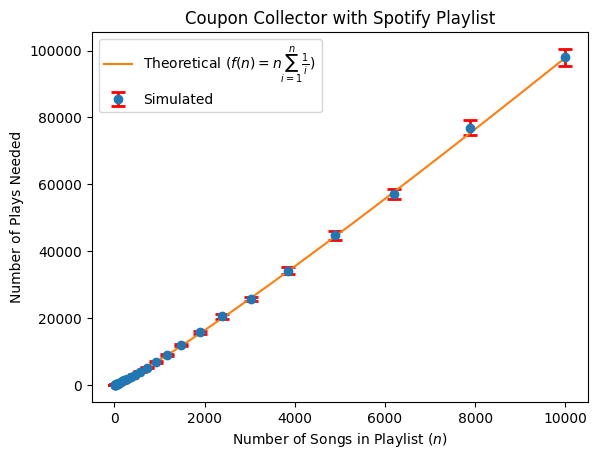

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def sim_coupon_collector(n, trials):
  collected = np.zeros((trials, n))
  iters = np.zeros(trials)
  unfinished = np.any(collected == 0, axis = 1)
  while np.any(unfinished):
    songs = np.floor(np.random.rand(np.sum(unfinished)) * n).astype(int)
    collected[unfinished,songs] += 1
    iters += unfinished
    unfinished = np.any(collected == 0, axis = 1)
  return iters

ns = np.logspace(1,4,30).astype(int)
trials = 100

results = np.zeros((len(ns), trials))

for i in range(len(ns)):
  results[i,:] += sim_coupon_collector(ns[i], trials)

std_errs = 1.96 * np.std(results, ddof=1, axis = 1)/np.sqrt(trials)
plt.errorbar(ns, np.mean(results, axis = 1), yerr=std_errs, fmt='o', ecolor='red', elinewidth=2, capsize=5, capthick=2)

ns = np.arange(10000)
theoretical = np.zeros(len(ns))

for i in range(len(ns)):
  theoretical[i] = ns[i] * sum([1/j for j in range(1, ns[i] + 1)])

plt.plot(ns, theoretical)
plt.title("Coupon Collector with Spotify Playlist")
plt.xlabel(r"Number of Songs in Playlist ($n$)")
plt.ylabel("Number of Plays Needed")
plt.legend([r"Theoretical ($f(n) = n \sum_{i = 1}^n \frac{1}{i}$)", "Simulated"])

### Theoretical
From lecture, the average number of songs we have to play should be
$$f(n) = n \sum_{i = 1}^n \frac{1}{i}$$
This aligns well with the data generated from our simulation.

### Derivation

Once we have played $i$ unique songs, the amount of time it takes to play the $i + 1$th unique song is a Geometric random variable with parameter $p = \frac{n - i}{n}$, since this is the fraction of unplayed songs which would represent a "success". If we define $X_i \sim Geom(\frac{n - i}{n})$ as this time, then the total expected time to play all songs in the playlist should be
$$E[\sum_{i = 0}^{n - 1} X_i] = \sum_{i = 0}^{n - 1} E[X_i] = \sum_{i = 0}^{n - 1} \frac{n}{n - i} = \frac{n}{n} + \frac{n}{n - 1} + \dots + \frac{n}{1} = n \sum_{i = 1}^n \frac{1}{i}$$

<hr>

**(b)** (10 pts) Suppose Spotify uses the following poor randomizer: it labels songs as $\{0,1,2,\ldots,n-1\}$, and after playing a song $i$, it then either plays song $(i+1) mod(n)$ or $(i-1)mod(n)$ with probability $1/2$ (i.e., the next or previous song, imagining the songs to be in a ring with $n-1$ wrapping around to $0$). Simulate this randomizer for $n=20$, assuming you always start at song $1$, and find the histogram of the *last song to be played* for the first time using this shuffler.   


<hr>

## Ans.


Text(0, 0.5, 'Frequency')

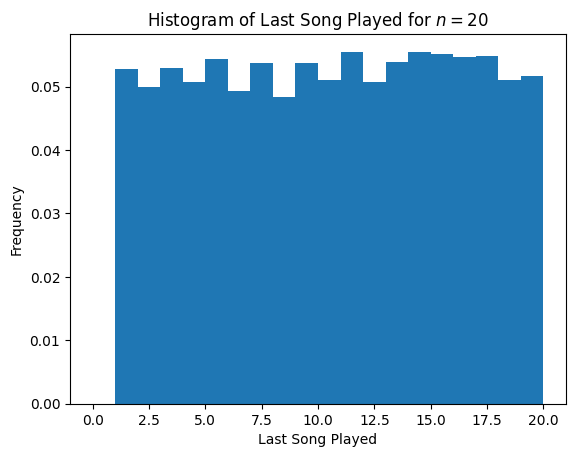

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def sim_randomizer(n):
  iters = 1
  cur_song = 0
  plays = np.zeros(n)
  plays[cur_song] += 1
  while np.any(plays == 0):
    if np.random.rand() > 0.5:
      cur_song = (cur_song + 1) % n
    else:
      cur_song = (cur_song - 1) % n
    plays[cur_song] += 1
    iters += 1
  return cur_song

num_trials = 10000
results = np.zeros(num_trials)

for i in range(num_trials):
  results[i] = sim_randomizer(20)

plt.hist(results, bins=[i for i in range(21)], density=True)
plt.title("Histogram of Last Song Played for $n = 20$")
plt.xlabel("Last Song Played")
plt.ylabel("Frequency")

The histogram appears mostly uniform, with the exception of song 1 ($i = 0$), since we always start at $i = 0$, so it can never be the last song played.

<hr><hr>

# Question 2 (The Gambler's Ruin)


In class, we saw the balanced gambler's ruin problem: two gambler's $A$ and $B$ start with $\$a$ and $\$b$ initially, and play a sequence of games, where each game is won by either player with probability $1/2$, with the winner giving $\$ 1$ to the loser. Play goes on till one player runs out of money.

<hr>

**(a)** (5 pts) We argued that when both players have the same initial budget, then each player is equally likely to win. We now want to run a simulation to find a similar formula for general initial budgets. To do so, assume the total budget is $a+b=20$, and run simulations to find the expected probability that $A$ wins for all values of $a$ from $\{0,1,\ldots,20\}$. Plot these, and use this to conjecture what the formula may be.


<hr>

## Ans.
### Observations

From running the simulation, we can see that:
1. **Linear Relationship**: The probability that A wins appears to increase linearly with $a$
2. **Boundary Cases**:
   - When $a = 0$: $P(A \text{ wins}) = 0$ (A starts with nothing)
   - When $a = 20$: $P(A \text{ wins}) = 1$ (B starts with nothing)

### Conjecture

Based on the simulation results, we conjecture that for the balanced gambler's ruin problem with total budget $a + b$:

$$\boxed{P(A \text{ wins}) = \frac{a}{a+b}}$$


In other words, the probability that Player A wins equals A's proportion of the total budget. This aligns very well with the simulation results.

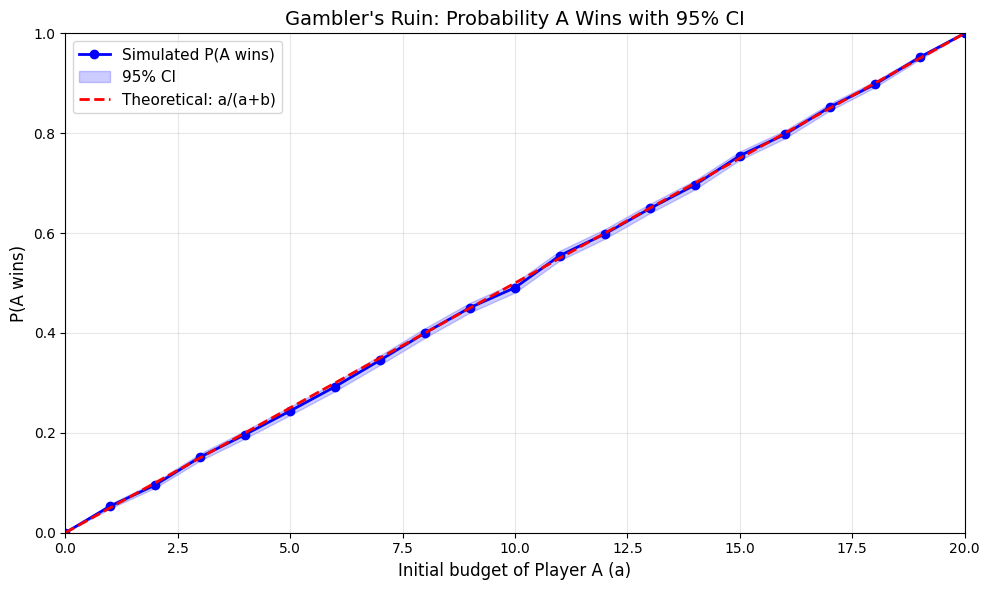

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_single_game(a, b):
    """
    Simulate a single gambler's ruin game.
    Returns 1 if A wins, 0 if B wins.
    """
    player_a = a
    player_b = b

    while player_a > 0 and player_b > 0:
        if np.random.random() < 0.5:
            player_a += 1
            player_b -= 1
        else:
            player_a -= 1
            player_b += 1

    return 1 if player_a > 0 else 0


def run_simulation(total_budget=20, num_simulations=10000):
    """
    Run simulations for all values of a from 0 to total_budget.
    Computes P(A wins) and 95% confidence intervals.
    """
    results = []

    for a in range(total_budget + 1):
        b = total_budget - a
        wins = 0

        for _ in range(num_simulations):
            wins += run_single_game(a, b)

        p_hat = wins / num_simulations
        se = np.sqrt(p_hat * (1 - p_hat) / num_simulations)  # standard error
        ci_low = p_hat - 1.96 * se
        ci_high = p_hat + 1.96 * se

        results.append((a, p_hat, ci_low, ci_high))

    return results


# Simulation
results = run_simulation(total_budget=20, num_simulations=10000)

# Results
a_values = [r[0] for r in results]
prob_values = [r[1] for r in results]
ci_low = [r[2] for r in results]
ci_high = [r[3] for r in results]

# Plot
plt.figure(figsize=(10, 6))

# simulated probabilities
plt.plot(a_values, prob_values, 'bo-', label='Simulated P(A wins)', linewidth=2, markersize=6)

# confidence interval shading
plt.fill_between(a_values, ci_low, ci_high, color='blue', alpha=0.2, label='95% CI')

# Theoretical line
theoretical = [a/20 for a in a_values]
plt.plot(a_values, theoretical, 'r--', label='Theoretical: a/(a+b)', linewidth=2)

plt.xlabel('Initial budget of Player A (a)', fontsize=12)
plt.ylabel('P(A wins)', fontsize=12)
plt.title('Gambler\'s Ruin: Probability A Wins with 95% CI', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


**(b)** (10 pts) Another question we can ask is how long it takes for either player to get ruined. To study this, simulate the gambler's ruin for a range of values of $a$ and $b$, and use this to try and guess the expected time to ruin.

Note: Convince yourself that the function must be symmetric in $a$ and $b$, so you can assume $a\leq b$. Try plotting the expected absorption times for selected values of $a$, while varying $b$.


<hr>

## Ans.
### Symmetry
We are only interested in how long it takes for either player to get ruined; we are not considering which player gets ruined. Because the game is balanced (each player has the same chances of winning each round), the results will be the same if player $A$ starts with $a$ and player $B$ starts with $b$ as if player $A$ starts with $b$ and player $B$ starts with $a$. The only difference is who will be favored to win, but we are not considering this now, so the function must be symmetric in $a$ and $b$.

### Conjecture

For the balanced gambler's ruin, we conjecture that the expected absorption time starting with $A$ having $a$ and $B$ having $b$ is

$$\boxed{\mathbb{E}[\text{time to ruin}] = a\,b}$$

This is symmetric in $a$ and $b$, as should be expected, and aligns with what we see in the simulation; when we fix $a$, the expected time to ruin varies linearly with $b$.

**Note:** The huge confidence intervals are an unfortunate side effect of the high variance of the gambler's ruin problem. The conjecture function still passes almost directly through the empirical means.

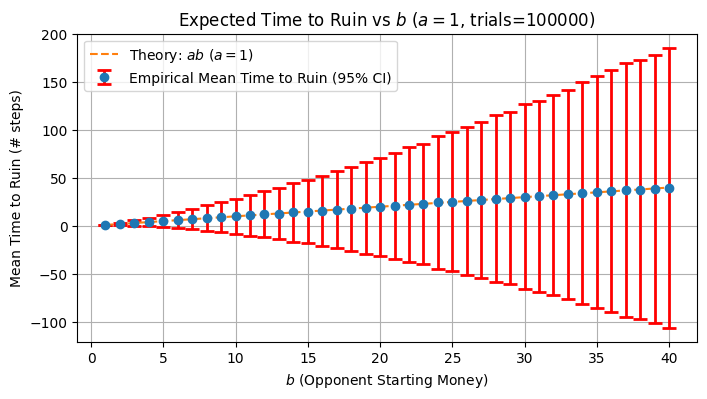

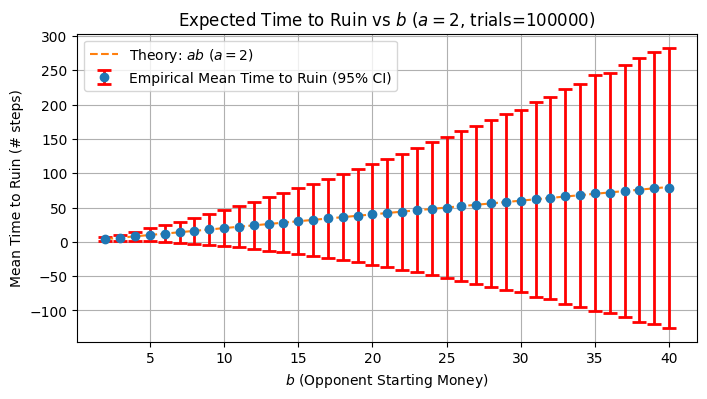

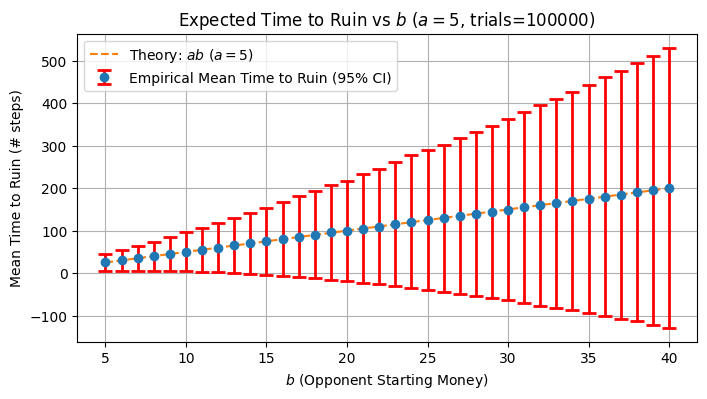

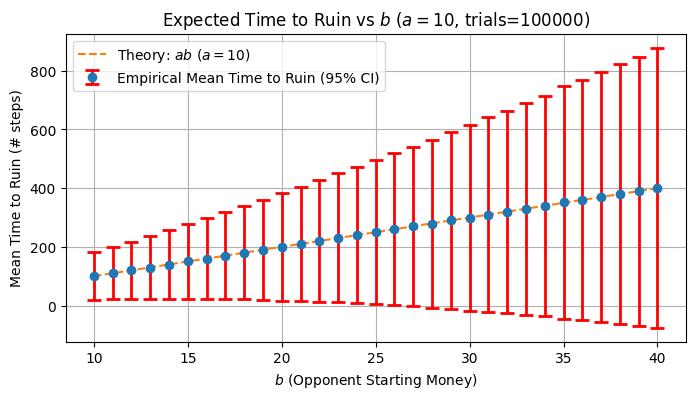

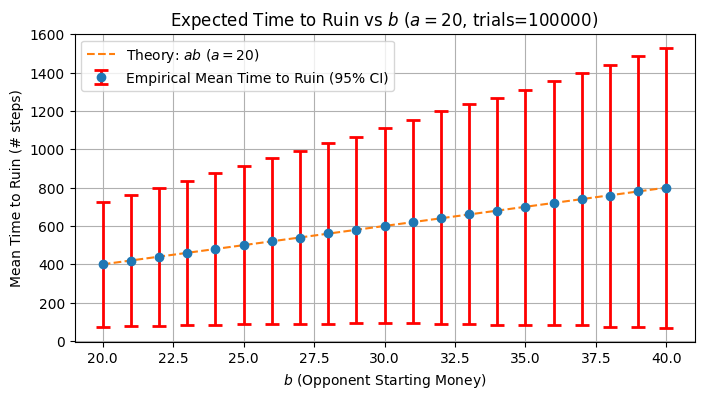

   a  b  mean_time  std_time  theory  frac_A_wins
0  1  1    1.00000  0.000000       1      0.49952
1  1  2    1.99766  1.400783       2      0.33278
2  1  3    3.00782  2.839151       3      0.25076
3  1  4    3.99654  4.507557       4      0.19788
4  1  5    4.99234  6.336654       5      0.16486


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(12345)

def simulate_absorption_time(a, b, trials=5000):
    N = a + b
    balances = np.full(trials, a, dtype=int)
    alive = (balances > 0) & (balances < N)
    times = np.zeros(trials, dtype=int)
    while alive.any():
        # increment time for alive runs
        times[alive] += 1
        # random increments (+1 or -1)
        moves = (np.random.rand(alive.sum()) < 0.5).astype(int) * 2 - 1
        balances[alive] += moves
        alive = (balances > 0) & (balances < N)
    # mean time across trials
    return times.mean(), times.std(ddof=1), (balances == N).mean()  # mean_time, std_time, fraction A wins

# parameters
a_values = [1, 2, 5, 10, 20]   # choose some a values
b_min, b_max = 1, 40
trials = 100000

results = []
for a in a_values:
    bs = list(range(max(a, b_min), b_max+1))
    mean_times = []
    std_times = []
    theory_times = []
    for b in bs:
        mean_t, std_t, frac_win = simulate_absorption_time(a, b, trials=trials)
        mean_times.append(mean_t)
        std_times.append(std_t)
        theory_times.append(a * b)
        results.append({'a': a, 'b': b, 'mean_time': mean_t, 'std_time': std_t, 'theory': a*b, 'frac_A_wins': frac_win})
    # plot for this a
    plt.figure(figsize=(8,4))
    plt.errorbar(bs, mean_times, yerr=std_times, fmt='o', ecolor='red', elinewidth=2, capsize=5, capthick=2, label='Empirical Mean Time to Ruin (95% CI)')
    plt.plot(bs, theory_times, linestyle='--', label=f'Theory: $ab$ ($a={a}$)')
    plt.xlabel(r'$b$ (Opponent Starting Money)')
    plt.ylabel('Mean Time to Ruin (# steps)')
    plt.title(f'Expected Time to Ruin vs $b$ ($a={a}$, trials={trials})')
    plt.legend()
    plt.grid(True)
    plt.show()

# dataframe for inspecting values
df = pd.DataFrame(results)
print(df.head())


<hr>

**(c)** (OPTIONAL) For parts $(a)$ and $(b)$, try and theoretically prove what you observe from your simulations!


<hr>

## Ans.
### Probability A Wins

### Expected Ruin Time


<hr><hr>

# Question 3 (Staffing a hospital)


Consider the model of the Fingerlakes Regional Hospital as shown below. New patients arrive at the reception at a rate of 20/hr and emergency patients enter the ER at a rate of 5/hr. The reception desk for non-emergency patients is managed by $n_R$ associates. Admission at the reception (not counting any queueing time) takes 5 minutes on average, regardless of whether the non-emergency patient is first-time or returning. The clinic is served by $d_C$ doctors with an average visit time of 15 minutes. About one in every four patients visiting the clinic are asked to return for a follow-up appointment that is, on average, 3 weeks (504 hours) later in time; another one-tenth of visitors to the clinic are referred to the internal ward (IW); the rest are treated and discharged. Patients arriving to the ER require about 1 hour of time with a doctor. The ER is staffed by $d_E$ doctors. Half of the patients in the ER are discharged after treatment, with the remainder referred to the IW. The average stay in the IW is about 72 hours and there are $n_I$ IW beds available. After a stay at the IW, 20\% of patients are discharged, whereas the rest are asked to return for a follow-up appointment as a non-emergency patient that is, on average, 3 weeks (504 hours) later in time. The reception, clinic, ER and IW all have their separate waiting areas and wait-lists, and serve patients on a FCFS basis.


![](hwq2figure.png)

**(a)** (5 pts)  Find bounds on the number of receptionists $n_R$, IW beds $N_I$, clinic doctors $d_C$ and ER doctors $d_E$ that the hospital requires to ensure it can keep up with its patient load?

<hr>

## Ans.

### Receptionists
New patients arrive at the reception at a rate of 20/hr. Of these patients, $\frac{1}{4}$ return for a follow-up. Additionally, $\frac{1}{10}$ are moved to the IW, and $\frac{4}{5}$ of those patients return for a follow up. Hence, the total number of visits to the clinic for a person arriving at the clinic reception is $Geom(1 - p_R)$ where $p_R = \frac{1}{4} + \frac{1}{10}(\frac{4}{5}) = \frac{33}{100}$, giving $\frac{1}{1 - p_R}$ as the expected number of visits per patient. Additionally, half the patients admitted to the ER are moved to the IW. Patients arrive at the ER at a rate of 5/hr, with no previous patients returning to the ER. Hence, patients admitted to the ER become clinic patients at a rate of $5(\frac{1}{2})(\frac{4}{5}) = 2$ per hour. The overall rate of patients arriving at the clinic reception *who have not been to the clinic before* at steady state is $\lambda_R = 20 + 2 = 22$.

The average service time per patient per receptionist is $\frac{1}{\mu_R} = \frac{1}{12}$ hour. Hence, at steady state, the amount of work coming into the system for the receptionists from time $t_0$ to time $t_0 + T$ is

$$\lambda_R T(\frac{1}{\mu_R})(\frac{1}{1 - p_R}) = T (22)(\frac{1}{12})(\frac{1}{1 - \frac{33}{100}}) = \frac{550}{201}T$$

The amount of work the receptionists can do in this time is $n_R T$. For stability, we need

$$n_R T > \frac{550}{201}T \implies n_R \geq 3$$

Therefore, $n_R$ must be at least $3$ to keep up with the patient load.

### Clinic Doctors

Similarly, the clinic doctors take an average of $\frac{1}{\mu_C} = \frac{1}{4}$ hour of time per patient per doctor. At steady state, the amount of work coming into the system for the clinic doctors from time $t_0$ to time $t_0 + T$ is

$$\lambda_R T(\frac{1}{\mu_C})(\frac{1}{1 - p_R}) = T(22)(\frac{1}{4})(\frac{1}{1 - \frac{33}{100}}) = \frac{550}{67}T$$

The amount of work the clinic doctors can do in this time is $d_C T$. For stability, we need

$$d_C T > \frac{550}{67}T \implies d_C \geq 9$$

Therefore, $d_C$ must be at least $9$ to keep up with the patient load.

### ER Doctors

Patients cannot return to the ER, so the only patients entering the ER are the $\lambda_{ER} = 5$ new arrivals per hour. The average time for an ER doctor to treat a patient is $\frac{1}{\mu_{ER}} = 1$. The amount of work coming into the system for ER doctors from time $t_0$ to time $t_0 + T$ is
$$\lambda_{ER} T (\frac{1}{\mu_{ER}}) = (5)(1)T = 5T$$

The amount of work the ER doctors can do in this time is $d_E T$. For stability, we need

$$d_E T > 5T \implies d_E \geq 6$$

Therefore, $d_E$ must be at least $6$ to keep up with the patient load.

### IW Beds

The number of patients entering the IW each hour is equal to the number entering from the clinic plus the number entering from the ER. $\frac{1}{10}$ of patients entering the clinic enter the IW, and $\frac{1}{2}$ of patients entering the ER enter the IW. Hence, the total rate of patients entering the IW at steady state is

$$\lambda_{IW} = \frac{1}{10}\lambda_R(\frac{1}{1 - p_R}) + \frac{1}{2}\lambda_{ER} = \frac{1}{10}(22)(\frac{1}{1 - \frac{33}{100}}) + \frac{1}{2}(5) = \frac{220}{67} + \frac{5}{2}$$

The average stay in the IW is $\frac{1}{\mu_{IW}} = 72$ hours. Therefore, the amount of work coming into the system for the IW from time $t_0$ to time $t_0 + T$ is

$$\lambda_{IW} T (\frac{1}{\mu_{IW}}) = (\frac{220}{67} + \frac{5}{2}) T (72) \approx 416.418 T$$

The amount of "work" the IW can do in this time is $N_I T$. For stability, we need

$$N_I T > 416.418 T \implies N_I \geq 417$$

Therefore, $N_I$ must be at least $417$ to keep up with the patient load.

<hr>

**(b)** (10 pts) Suppose the hospital chooses to run with $d_E=7$ doctors in the ER, $d_C=10$ doctors in the clinic, and $n=500$ beds in the IW. Approximate the average time spent in the clinic (including treatment but not including reception) and the average number of busy clinic doctors.

<hr>

## Ans.

Assuming we have sufficient receptionists to form a stable queue, then referring back to the logic we used above in (a), the steady state arrival rate to the clinic is
$$\lambda_R(\frac{1}{1 - p_R}) = 22(\frac{1}{1 - \frac{33}{100}}) = \frac{2200}{67} \text{ per hour}$$
The average time to treat a patient is $\frac{1}{4}$ hour. Using Little's Law, the expected number of people currently being treated (and hence the average number of busy doctors) should be
$$E[I] = \lambda E[w] = \frac{2200}{67}(\frac{1}{4}) = \frac{550}{67}$$
The queue is stable since
$$\frac{\lambda}{\mu} = \frac{2200}{67}(\frac{1}{4}) = \frac{550}{67} < 10 = d_C$$
Hence, the average number of busy clinic doctors is $\frac{550}{67} \approx 8.2090$.

Average time spent in the clinic (including treatment and waitlist but not reception) is
$$E[W_t] = \frac{1}{\mu - \lambda}$$
where $w$ is the total time a person spends in the clinic and $\lambda$ is the arrival rate. This should be approximately equal to the average number of busy clinic doctors as long as the number of people in the clinic does not exceed the number of clinic doctors often. Hence, we find
$$E[\text{Busy clinic doctors}] \approx \frac{2200}{67}() = $$


<hr>

**(c)** (10 pts) Suppose the hospital chooses to run with $d_E=7$ doctors in the ER, $d_C=10$ doctors in the clinic, and $n=500$ beds in the IW. Compute the probability that the hospital will simultaneously have no patients in the ER and no patients in the clinic.

<hr>

## Ans.

Assume again that there are enough receptionists to form a stable queue. The probability that the hospital will have no patients is
The probability that the ER will have no patients is

<hr>

**(d)** (40 pts) Build a simulator for the above model, assuming the external arrivals to the reception and ER are Poisson processes, and all service times are exponential and all routings are independent. You can re-use any of the code we provided in the recitations.

Use your simulator to study the following:

$(i)$ Plot the total number of patients waiting in the hospital when the number of doctors and beds is $1$ more than your suggestions in part $(a)$, and when it is $1$ less than your suggestions in part $(a)$. You should simulate over a long enough time horizon to be able to determine whether the numbers stabilize, or grow unbounded.

$(ii)$ Simulate the configuration in part $(b)$, and plot the average time spent by patients in the clinic, and the average number of busy clinic doctors. How do these compare to the answers in part $(b)$?

<hr>

## Ans.

Average Time Spent by Patients in Clinic: 0.3064082663189228
Time-Weighted Average Number of Busy Clinic Doctors: 7.911012979467813


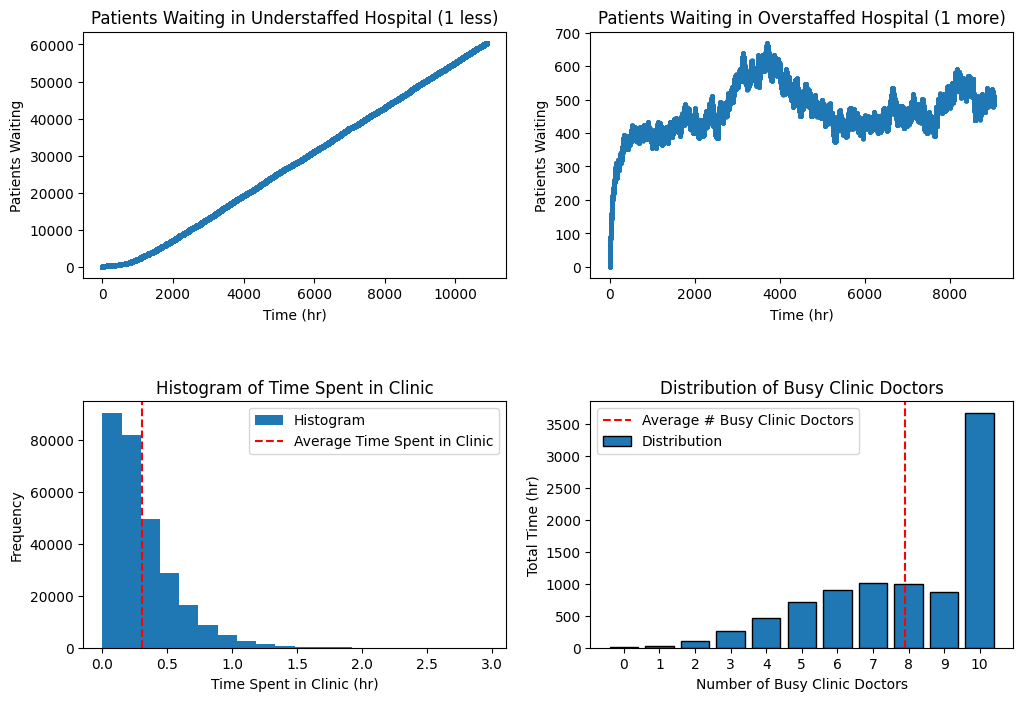

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

np.random.seed(0)

class HospitalSim:
  """
  Class for running hospital simulation
  """
  # The following variables describe the rates at which patients are processed
  # at each process in the hospital as well as the fractions of patients
  # which transition between each process

  clinic_arrival_rate = 20
  ER_arrival_rate = 5
  reception_rate = 12
  clinic_treatment_rate = 4
  IW_rate = 1/72
  ER_treatment_rate = 1
  followup_rate = 1/504

  clinic_followup_fraction = 1/4
  clinic_IW_fraction = 1/10
  IW_followup_fraction = 4/5
  ER_IW_fraction = 1/2

  def __init__(self, nR, nI, dC, dE):
    self.receptionists = nR
    self.IW_beds = nI
    self.clinic_doctors = dC
    self.ER_doctors = dE

    # Only store length of queues instead of queues themselves since
    # all patients are interchangeable (except for clinic queue)
    self.reception_queue = 0
    self.reception = 0

    # Queue of arrival times for patients in the clinic waiting queue
    self.clinic_waiting_queue = deque()
    # Number of patients waiting in the clinic waiting queue
    self.clinic_num_waiting = 0
    # Number of patients being actively treated in the clinic
    self.clinic_num = 0
    # List of arrival times for patients currently being treated in the clinic
    self.clinic_list = []

    self.followups = 0

    self.ER_queue = 0
    self.ER = 0

    self.IW_queue = 0
    self.IW = 0

    # Times spent in clinic by patients who have left clinic
    self.clinic_time = []
    self.busy_clinic_doctors = [0]
    self.time = [0]
    self.waiting = [0]

  def reception_arrival(self):
    """
    Add a patient to the reception or reception queue
    """
    if self.reception < self.receptionists:
      self.reception += 1
    else:
      self.reception_queue += 1

  def ER_arrival(self):
    """
    Add a patient to the ER or ER queue
    """
    if self.ER < self.ER_doctors:
      self.ER += 1
    else:
      self.ER_queue += 1

  def clinic_admission(self):
    """
    Admit a patient from reception into the clinic or clinic queue
    """
    # Update reception queue
    if self.reception_queue > 0:
      self.reception_queue -= 1
    else:
      self.reception -= 1

    # Update clinic queue
    if self.clinic_num < self.clinic_doctors:
      self.clinic_num += 1
      self.clinic_list.append(self.time[-1])
    else:
      self.clinic_num_waiting += 1
      self.clinic_waiting_queue.append(self.time[-1])

  def clinic_treatment(self):
    """
    Finish treating a patient from the clinic and redirect them accordingly
    """
    # Update clinic queue
    if self.clinic_num_waiting > 0:
      self.clinic_num_waiting -= 1
      admitted = self.clinic_waiting_queue.popleft()
      treated = np.floor(np.random.rand() * self.clinic_num).astype(int)
      self.clinic_time.append(self.time[-1] - self.clinic_list[treated])
      self.clinic_list[treated] = admitted
    else:
      self.clinic_num -= 1
      treated = np.floor(np.random.rand() * self.clinic_num).astype(int)
      self.clinic_time.append(self.time[-1] - self.clinic_list.pop(treated))

    choose_event = np.random.rand()
    if choose_event < self.clinic_followup_fraction:
      # Patient sent for followup
      self.followups += 1
    elif choose_event < self.clinic_followup_fraction + self.clinic_IW_fraction:
      # Patient sent to IW
      if self.IW < self.IW_beds:
        self.IW += 1
      else:
        self.IW_queue += 1

  def IW_treatment(self):
    """
    Finish treating a patient from the IW and redirect them accordingly
    """
    # Update IW queue
    if self.IW_queue > 0:
      self.IW_queue -= 1
    else:
      self.IW -= 1

    choose_event = np.random.rand()
    if choose_event < self.IW_followup_fraction:
      # Patient sent for followup
      self.followups += 1

  def ER_treatment(self):
    """
    Finish treating a patient from the ER and redirect them accordingly
    """
    # Update ER queue
    if self.ER_queue > 0:
      self.ER_queue -= 1
    else:
      self.ER -= 1

    choose_event = np.random.rand()
    if choose_event < self.ER_IW_fraction:
      # Patient sent to IW
      if self.IW < self.IW_beds:
        self.IW += 1
      else:
        self.IW_queue += 1

  def cur_waiting(self):
    """
    Return the total number of patients currently waiting in the hospital
    """
    return self.reception_queue + self.clinic_num_waiting + self.ER_queue + self.IW_queue + self.reception + self.clinic_num + self.ER + self.IW

  def step(self):
    """
    Run one step of the hospital simulation
    """
    event_rate = self.clinic_arrival_rate + self.ER_arrival_rate + self.reception * self.reception_rate + self.clinic_num * self.clinic_treatment_rate + self.IW * self.IW_rate + self.ER * self.ER_treatment_rate + self.followups * self.followup_rate
    next_event_time = np.random.exponential(scale=1/event_rate)
    self.time.append(self.time[-1] + next_event_time)

    choose_event = np.random.rand()

    if choose_event < self.clinic_arrival_rate/event_rate:
      self.reception_arrival()
    elif choose_event < (self.clinic_arrival_rate + self.ER_arrival_rate)/event_rate:
      # Arrival to ER
      self.ER_arrival()
    elif choose_event < (self.clinic_arrival_rate + self.ER_arrival_rate + self.reception * self.reception_rate)/event_rate:
      # Receptionist finishes admitting patient to clinic
      self.clinic_admission()
    elif choose_event < (self.clinic_arrival_rate + self.ER_arrival_rate + self.reception * self.reception_rate + self.clinic_num * self.clinic_treatment_rate)/event_rate:
      # Clinic patient finishes treatment
      self.clinic_treatment()
    elif choose_event < (self.clinic_arrival_rate + self.ER_arrival_rate + self.reception * self.reception_rate + self.clinic_num * self.clinic_treatment_rate + self.IW * self.IW_rate)/event_rate:
      # IW treatment finishes
      self.IW_treatment()
    elif choose_event < (self.clinic_arrival_rate + self.ER_arrival_rate + self.reception * self.reception_rate + self.clinic_num * self.clinic_treatment_rate + self.IW * self.IW_rate + self.ER * self.ER_treatment_rate)/event_rate:
      # ER patient finishes treatment
      self.ER_treatment()
    else:
      # Followup patient returns to clinic
      self.followups -= 1
      self.reception_arrival()

    self.waiting.append(self.cur_waiting())
    self.busy_clinic_doctors.append(self.clinic_num)

  def print_info(self):
    """
    Print info about current state of hospital
    """
    print(f"Reception: {self.reception}, Clinic: {self.clinic}, ER: {self.ER}, IW: {self.IW}")
    print(f"Queues - Reception: {self.reception_queue}, Clinic: {self.clinic_num_waiting}, ER: {self.ER_queue}, IW: {self.IW_queue}")

  def plot(self, axs=None):
    if axs:
      axs.scatter(self.time, self.waiting, s=5)
      axs.set_xlabel("Time (hr)")
      axs.set_ylabel("Patients Waiting")
    else:
      plt.plot(self.time, self.waiting)

  def hist(self, axs):
    axs.hist(self.clinic_time);

num_steps = 1_000_000

nR = 3
nI = 417
dC = 9
dE = 6

hosp_overstaffed = HospitalSim(nR + 1, nI + 1, dC + 1, dE + 1)
hosp_understaffed = HospitalSim(nR - 1, nI - 1, dC - 1, dE - 1)
hosp_b = HospitalSim(10, 500, 10, 7)

for _ in range(num_steps):
  hosp_overstaffed.step()
  hosp_understaffed.step()
  hosp_b.step()

fig, axs = plt.subplots(2, 2, figsize=(12,8))
hosp_understaffed.plot(axs = axs[0,0])
axs[0,0].set_title("Patients Waiting in Understaffed Hospital (1 less)")
hosp_overstaffed.plot(axs=axs[0,1])
axs[0,1].set_title("Patients Waiting in Overstaffed Hospital (1 more)")

axs[1,0].hist(hosp_b.clinic_time, bins=20, label="Histogram")
# axs[1,0].plot(np.arange(len(hosp_b.clinic_time)), hosp_b.clinic_time)
axs[1,0].set_title("Histogram of Time Spent in Clinic")
axs[1,0].set_xlabel("Time Spent in Clinic (hr)")
axs[1,0].set_ylabel("Frequency")
axs[1,0].axvline(x=np.mean(hosp_b.clinic_time), color='r', linestyle='--', label='Average Time Spent in Clinic')
axs[1,0].legend()

print(f"Average Time Spent by Patients in Clinic: {np.mean(hosp_b.clinic_time)}")

# axs[1,1].scatter(hosp_b.time, hosp_b.busy_clinic_doctors, s = 5, alpha = 0.3)
# axs[1,1].plot(hosp_b.time, hosp_b.busy_clinic_doctors, linewidth = 1, alpha = 0.3)
busy_clinic_doctors = np.array(hosp_b.busy_clinic_doctors)
time = np.array(hosp_b.time)
clinic_busy_frequency = [np.sum(time[1:][busy_clinic_doctors[:-1] == i] - time[:-1][busy_clinic_doctors[:-1] == i]) for i in range(11)]

# Credit: Bar chart code generated by Google Copilot
categories = [str(i) for i in range(11)]

# Create positions for the bars on the x-axis
pos = np.arange(11)

# Plotting the bar chart
plt.bar(pos, clinic_busy_frequency, edgecolor='black', label='Distribution')

# Label the x-axis ticks with your categories
plt.xticks(pos, categories)

axs[1,1].set_title("Distribution of Busy Clinic Doctors")
axs[1,1].set_xlabel("Number of Busy Clinic Doctors")
axs[1,1].set_ylabel("Total Time (hr)")

avg_busy_clinic_doctors = sum(hosp_b.busy_clinic_doctors[i] * (hosp_b.time[i + 1] - hosp_b.time[i]) for i in range(num_steps))/hosp_b.time[num_steps]

axs[1,1].axvline(x=avg_busy_clinic_doctors, color='r', linestyle='--', label='Average # Busy Clinic Doctors')
axs[1,1].legend()

plt.subplots_adjust(hspace=0.5)

print(f"Time-Weighted Average Number of Busy Clinic Doctors: {avg_busy_clinic_doctors}")

#### (i)
When the number of doctors, beds, and receptionists is 1 less than the lower bounds we found in (a), the number of patients waiting in the hospital clearly grows indefinitely. When these numbers are one more than the lower bound we found, the number of patients waiting appears to reach a stable value around 400 or 500 and does not continue growing over time. Note that because we were asked for the "total number of patients waiting *in the hospital*", we counted both patients who were on the wait-lists and patients who were actively being treated or admitted as long as they were in the hospital.

#### (ii)

The average time spent by patients in the clinic was around $0.30641$ hours.  The histogram shows the distribution of clinic visit lengths for each of the patients who visited the clinic. The time-weighted average number of busy clinic doctors was around $7.9110$ doctors, which is relatively close to our predicted value of $8.2090$. The bar chart shows how often there were $n$ busy clinic doctors for each $n \in \{0, \dots, 10\}$ over the course of the entire simulation.